본 함수는 R의 `Return.portfolio()` 함수를 카피한 것으로, R 함수의 깃허브 주소는 다음과 같습니다

```
https://github.com/R-Finance/PerformanceAnalytics/blob/master/R/Return.portfolio.R
```

먼저 필요한 패키지들을 불러옵니다

In [16]:
import pandas as pd
import numpy as np
import sys
from progressbar import ProgressBar
from datetime import timedelta 

R의 `endpoints()` 함수는 원하는 주기별 위치를 찾아주는 함수입니다. (예: 데이터에서 월말에 해당하는 날짜는 몇번째 인덱스에 위치하는가)
해당 함수를 그대로 복제해주도록 합니다.

In [20]:
def endpoints(R, freq):    
    
    # freq: W, M, Q, Y    
    if isinstance(R.index, pd.DatetimeIndex) :
    
        s = pd.Series(np.arange(R.shape[0]), index = R.index)
        ep = s.resample(freq).max()    
        return(ep)
    
    else:
        sys.exit('Error: R is not DatetimeIndex type')

R의 `periodicity()` 함수는 xts 데이터의 주기(초/분/시/일/월...)를 확인해주는 함수입니다. 해당 함수와 유사하게 복제해주도록 합니다. 데이터의 각 index 간 몇초가 차이 나는지를 계산해줍니다.

In [21]:
def periodicity(R):
    med  = np.median(np.diff(R.index.values))
    seconds = int(med.astype('timedelta64[s]').item().total_seconds())  
    
    return(seconds)

마지막으로 `ReturnPortfolio()` 함수를 생성합니다. 각 인자는 다음과 같습니다.

- R: 수익률. 데이터프레임 및 인덱스가 Datetime 형태로 입력되야 함
- weights: 원하는 시점별 리밸런싱 비중. 데이터프레임 및 인덱스가 Datetime 형태로 입력되야 함
- rebalance_on: 리밸런싱 주기. Y(연), Q(분기), M(월), W(주) 선택 가능하며 공백으로 둘 시 최초 1회 리밸런싱만 실시

In [50]:
# R: Return, form of dataframes with indexe as Datetime
# weights: weights, form of single list or dataframe
# rebalance_on: rebalancing period, form of character

def ReturnPortfolio(R, weights, rebalance_on = [np.nan, 'Y', 'Q', 'M', 'W']) :
    
    rebalance_on = rebalance_on[0]        
    start_date = (R.index[0] + timedelta(seconds = -periodicity(R))).strftime('%Y-%m-%d')
    
    # When rebalancing weights are fixed (single list form)
    if type(weights) == list:
        
        if pd.isnull(rebalance_on):
            # then use the weights only at the beginning of the returns series, without rebalancing
            weights = pd.DataFrame([weights], columns = R.columns)
            weights.index = [start_date]
        
        else :
            ep = endpoints(R, rebalance_on)
            #  generate a time series of the given weights at the endpoints
            weights = pd.DataFrame(np.repeat([weights],len(ep) + 1,axis=0), columns = R.columns)
            ep_list = ep.index.format()    
            weights.index = [start_date] + ep_list

    weights.index = pd.to_datetime(weights.index)
    
    if R.isnull().values.any() :
        print("NA's detected: filling NA's with zeros")
        R[np.isnan(R)] = 0

    if not isinstance(R.index, pd.DatetimeIndex) :
        sys.exit('The index of returns is not Datetime.')    

    if R.shape[1] != weights.shape[1] :
        sys.exit("The number of columns in the Return and Weights are different.")

    if R.index[-1] < weights.index[0] + pd.DateOffset(days=1) :
        sys.exit("The starting date for rebalancing is incorrect.")   
        
    if (weights.sum(axis = 1) != 1).values.sum() >= 1 :
        sys.exit("There is a rebalancing point with a sum of weight than 1.")
    

    # Subset the R object if the first rebalance date is after the first date 
    # in the return series
    if R.index[0] < weights.index[0] :
        R = R.loc[R.index >= weights.index[0] + pd.DateOffset(days=1)]    

    df_zero1 = pd.DataFrame(data = np.zeros(shape = (R.shape[0], R.shape[1])), index = R.index, columns = [R.columns])
    df_zero2 = pd.DataFrame(data = np.zeros(shape = R.shape[0]), index = R.index, columns = ['Portfolio'])
    
    # bop = beginning of period
    # eop = end of period
    # Initialize objects
    bop_value = df_zero1.copy()
    eop_value = df_zero1.copy()
    bop_weights = df_zero1.copy()
    eop_weights = df_zero1.copy()
    period_contrib = df_zero1.copy()

    bop_value_total = df_zero2.copy()
    eop_value_total = df_zero2.copy()
    ret = df_zero2.copy()

    # The end_value is the end of period total value from the prior period
    end_value = 1

    # initialize counter
    k = 0
    
    # end length of for loop value
    end = (len(weights) - 1) if len(weights) > 1 else 1
    
    pbar = ProgressBar()
    
    for i in pbar(range(0 , end)) :
        
        # identify rebalance from and to dates and           
        # subset the Returns object
        fm = weights.index[i] + pd.DateOffset(days=1)        
        
        if (i == (len(weights) - 1)):        
            to = R.index[-1]
        else :
            to = weights.index[i + 1]            
        
        returns = R.loc[fm : to, ]

        # Only enter the loop if we have a valid returns object
        if len(returns) >= 1 :
            
            # inner loop counter        
            jj = 0

            for j in range(0, len(returns) ) :

                # We need to know when we are at the start of this inner loop so we can
                # set the correct beginning of period value. We start a new inner loop
                # at each rebalance date.
                
                # Compute beginning of period values                    
                if jj == 0 :
                    bop_value.iloc[k, :] = end_value * weights.iloc[i, :].values
                else :
                    bop_value.iloc[k, :] = eop_value.iloc[k-1, :]

                bop_value_total.iloc[k] = bop_value.iloc[k, :].sum()                
                                
                # Compute end of period values
                eop_value.iloc[k, :] = (1 + returns.iloc[j, :]).values * bop_value.iloc[k, :].values
                eop_value_total.iloc[k] = eop_value.iloc[k, :].sum()

                # Compute BOP and EOP weights
                bop_weights.iloc[k, :] = bop_value.iloc[k, :] / float(bop_value_total.iloc[k])
                eop_weights.iloc[k, :] = eop_value.iloc[k, :] / float(eop_value_total.iloc[k])
                                   
                # Compute period contribution
                period_contrib.iloc[k, :] = returns.iloc[j, :].values * bop_value.iloc[k, :].values / sum(bop_value.iloc[k, :])
                
                # Compute portfolio returns
                ret.iloc[k] = eop_value_total.iloc[k] / end_value - 1
                
                # Update end_value
                end_value = float(eop_value_total.iloc[k])

                # increment the counters            
                jj += 1
                k += 1

    result = {'returns' : ret, 'BOP_weights' : bop_weights, 'EOP_weights' : eop_weights, 'contribution': period_contrib,
             'BOP_value' : bop_value, 'EOP_value' : eop_value}   
    
    
    return(result)

결과물은 다음과 같습니다

- returns: 포트폴리오 수익률
- BOP_weights: 매일 시가의 자산별 비중
- EOP_weights: 매일 종가의 자산별 비중
- contribution: 매일 자산별 수익 기여도
- BOP_value: 매일 시가의 자산별 가치
- EOP_value: 매일 종가의 자산별 자산

함수 테스트를 위해 웹에서 데이터를 받아오도록 하겠습니다.

- SPY: S&P 500
- TLT: 장기채

In [48]:
import pandas as pd
import numpy as np
from progressbar import ProgressBar
import pandas_datareader as web

tickers = ['SPY', 'TLT']
all_data = {}
for ticker in tickers:
    all_data[ticker] = web.DataReader(ticker, 'yahoo', start = '2003-01-01')    

prices = pd.DataFrame({tic: data['Adj Close'] for tic, data in all_data.items()})
R = prices.pct_change(1).dropna()

# 1. 60대 40 포트폴리오, 리밸런싱 없음

초기 비중 그대로 유지하는 경우 입니다. rebalance_on을 공백으로 둡니다.

In [53]:
reb_no = ReturnPortfolio(R, [0.6, 0.4])

100% |########################################################################|


포트폴리오의 수익률, 비중, 기여도 등이 계산됩니다.

In [52]:
reb_no

{'returns':             Portfolio
 Date                 
 2003-01-02   0.008971
 2003-01-03   0.002783
 2003-01-06   0.009794
 2003-01-07  -0.000161
 2003-01-08  -0.007019
 ...               ...
 2021-02-17   0.001715
 2021-02-18  -0.004205
 2021-02-19  -0.004577
 2021-02-22  -0.007672
 2021-02-23   0.000224
 
 [4567 rows x 1 columns],
 'BOP_weights':                  SPY       TLT
 Date                          
 2003-01-02  0.600000  0.400000
 2003-01-03  0.613807  0.386193
 2003-01-06  0.613985  0.386015
 2003-01-07  0.618746  0.381254
 2003-01-08  0.617314  0.382686
 ...              ...       ...
 2021-02-17  0.757301  0.242699
 2021-02-18  0.756177  0.243823
 2021-02-19  0.756139  0.243861
 2021-02-22  0.758274  0.241726
 2021-02-23  0.758258  0.241742
 
 [4567 rows x 2 columns],
 'EOP_weights':                  SPY       TLT
 Date                          
 2003-01-02  0.613807  0.386193
 2003-01-03  0.613985  0.386015
 2003-01-06  0.618746  0.381254
 2003-01-07  0.617314  0.382

비중을 확인헤보겠습니다.

In [54]:
reb_no['BOP_weights'].head()

,SPY,TLT
Date,,
2003-01-02,0.600000,0.400000
2003-01-03,0.613807,0.386193
2003-01-06,0.613985,0.386015
2003-01-07,0.618746,0.381254
2003-01-08,0.617314,0.382686


<AxesSubplot:xlabel='Date'>

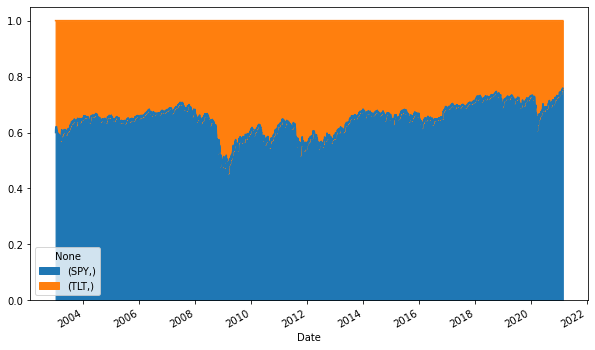

In [55]:
reb_no['BOP_weights'].plot.area(figsize = (10, 6))

# 2. 60대 40 포트폴리오, 월별 리밸런싱

매월 말 60대 40으로 다시 리밸런싱 하는 포트폴리오 입니다. 인자에 'M'을 추가합니다.

In [56]:
reb_m = ReturnPortfolio(R, [0.6, 0.4], 'M')

100% |########################################################################|


비중을 확인해보면 리밸런싱으로 인해 60대 40 비중이 계속 유지됩니다.

<AxesSubplot:xlabel='Date'>

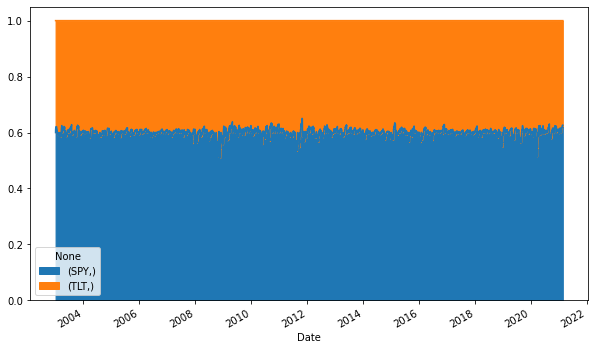

In [57]:
reb_m['BOP_weights'].plot.area(figsize = (10, 6))

포트폴리오의 수익률을 확인해보겠습니다.

<AxesSubplot:xlabel='Date'>

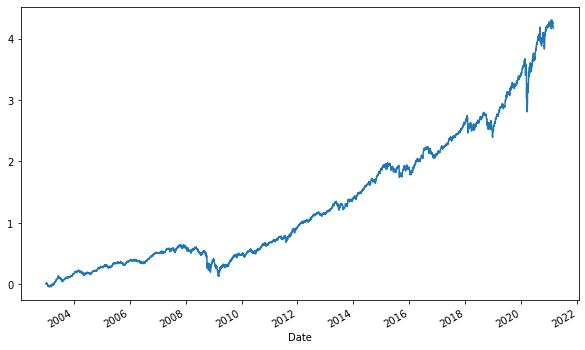

In [62]:
reb_m['returns'].add(1).cumprod().add(-1).plot(legend = False, figsize = (10, 6))